# Jet euclidean distances

**Goal:** The other folder GraphNN explored using a graph NN for solving the combinatorial jet pairing problem.

However, I don't think I first fully explored the impact of doing jet pairing just using the Euclidean distances, so that's what I want to do here.

I'm going to start this study from the MNT level. I think it's easiest to just apply the trigger cut, but it should be straight-forward to use some masks and apply both the 4-jet and $b$-tagging cuts as well.

**Table of Contents:**
1. Truth level studies
2. Reco level studies
3. Scaling up to > 4 jets (?)


In [1]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt

import uproot
from uproot_methods.classes.TLorentzVector import TLorentzVectorArray

%load_ext autoreload
%autoreload 2

### Load in the data

For starters, just mc16a SM NR.


In [2]:
filename = "../../public/hh4b/SMNR/user.jagrundy.HH4B.450000.SM_HH.MC16a-2015-2016.AB21.2.91-MAR20-0.full_MiniNTuple.root/user.jagrundy.20736236._000001.MiniNTuple.root"
treename = "XhhMiniNtuple" 

f = uproot.open(filename)
tree = f[treename]

In [3]:
import dask
import dask.bag as db

In [4]:
smText = "$\mathbf{ATLAS}$ Simulation Internal\n"
smText += "SM NR mc16a MAR20 MNT"
smText += "Just XhhCommon preselection"

In [5]:
for k in tree.keys():
    if 'truth' in k.decode():
        print(k)

b'ntruth'
b'truth_E'
b'truth_pt'
b'truth_phi'
b'truth_eta'
b'truth_pdgId'
b'truth_status'
b'truth_barcode'
b'truth_is_higgs'
b'truth_is_bhad'
b'truth_Bdecay_x'
b'truth_Bdecay_y'
b'truth_Bdecay_z'
b'truth_nParents'
b'truth_parent_pdgId'
b'truth_parent_barcode'
b'truth_parent_status'
b'truth_nChildren'
b'truth_child_pdgId'
b'truth_child_barcode'
b'truth_child_status'
b'truth_mtt'
b'truthjet_antikt4_pt'
b'truthjet_antikt4_eta'
b'truthjet_antikt4_phi'
b'truthjet_antikt4_m'
b'truthjet_antikt10_pt'
b'truthjet_antikt10_eta'
b'truthjet_antikt10_phi'
b'truthjet_antikt10_m'


In [6]:
tpdg = tree.array('truth_pdgId')

In [7]:
w = tree.array('mcEventWeight')

In [8]:
x = np.vstack(tpdg)

In [9]:
x.shape

(777150, 6)

In [10]:
len(tpdg)

777150

In [11]:
ntruth = tree.array('ntruth')

In [12]:
np.min(ntruth),np.max(ntruth)

(6, 6)

In [13]:
ntruth = tree.array('ntruth')

The first time I try to load ntruth, it takes a bit of time, so I was wondering if dask might be a better option.

In [14]:
import pandas as pd

## 1. Truth-level studies

After looking at distributions, it would also be interesting to scale the features, or (maybe) derive some weights to find a weighted distribution function?


In [15]:
# Get the pdgs and parent and child barcodes

pdg            = np.vstack(tree.array('truth_pdgId'))
barcode        = np.vstack(tree.array('truth_barcode'))

In [16]:
higgs_barcodes = barcode[pdg == 25].reshape(-1,2)
higgs_barcodes.shape

(777150, 2)

I need to be careful to only access the parent information this way for truth $b$-quarks, b/c the higgs don't always have an attatched parent.

In [17]:
pbarc = tree.array('truth_parent_barcode')

In [18]:
b_parent_barcodes = np.vstack([[x[0] for pdg,x in zip(pdgs,ps) if np.abs(pdg) == 5] \
                                for pdgs,ps in zip(pdg,pbarc) ])

In [19]:
pt  = np.vstack(tree.array('truth_pt'))
eta = np.vstack(tree.array('truth_eta'))
phi = np.vstack(tree.array('truth_phi'))
E   = np.vstack(tree.array('truth_E'))

In [20]:
h_pt =  pt[pdg == 25].reshape(-1,2)
h_eta = eta[pdg == 25].reshape(-1,2)
h_phi = phi[pdg == 25].reshape(-1,2)
h_E   = E[pdg == 25].reshape(-1,2)

In [21]:
d_hpt = h_pt[:,0]-h_pt[:,1]
np.min(d_hpt)

0.00012207031

The truth Higgs's are sorted by $p_T$.

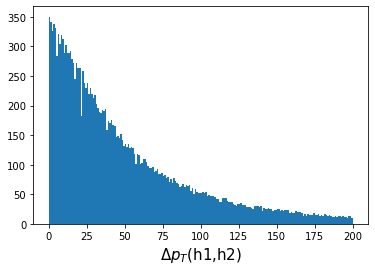

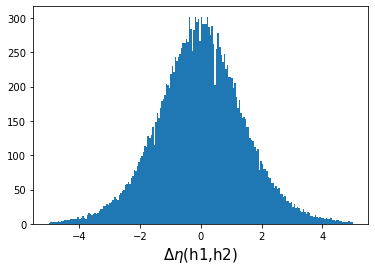

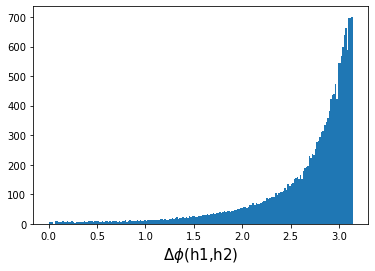

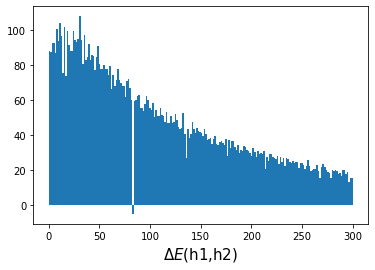

In [22]:
for v, xrange, xlabel in zip([h_pt,h_eta,h_phi,h_E],
                             [(0,200),(-5,5),None,(0,300)],
                             ['$p_T$','$\eta$','$\phi$','$E$']):
    plt.figure()
    dv = v[:,0]-v[:,1]
    if xlabel == '$\phi$':
        dv = np.arccos(np.cos(dv))
        
    plt.hist(dv,200,xrange,weights=w)
    plt.xlabel('$\Delta$'+xlabel+'(h1,h2)',fontsize=15)
plt.show()

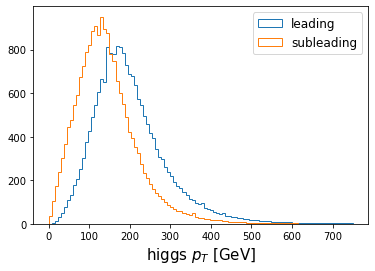

In [23]:
plt.hist(h_pt[:,0],100,(0,750),histtype='step',weights=w,label='leading')
plt.hist(h_pt[:,1],100,(0,750),histtype='step',weights=w,label='subleading')
plt.xlabel('higgs $p_T$ [GeV]',fontsize=15)
plt.legend(fontsize=12)
plt.show()

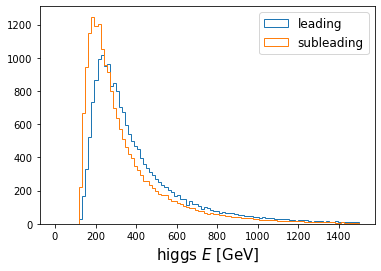

In [24]:
plt.hist(h_E[:,0],100,(0,1500),histtype='step',weights=w,label='leading')
plt.hist(h_E[:,1],100,(0,1500),histtype='step',weights=w,label='subleading')
plt.xlabel('higgs $E$ [GeV]',fontsize=15)
plt.legend(fontsize=12)
plt.show()

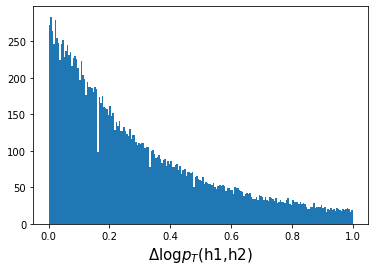

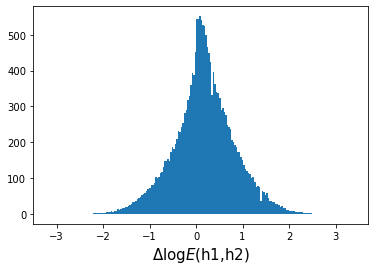

In [25]:
for v, xrange, xlabel in zip([h_pt,h_E],
                             [(0,1),None],
                             ['$p_T$','$E$']):
    plt.figure()
    dv = np.log(v[:,0])-np.log(v[:,1])
        
    plt.hist(dv,200,xrange,weights=w)
    plt.xlabel('$\Delta \log$'+xlabel+'(h1,h2)',fontsize=15)
plt.show()

Ok - interesting: for the SM, the Higgs are mostly back-to-back. It would be nice to see if this stays the same or not for the lower masses.

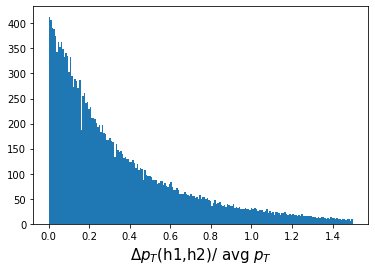

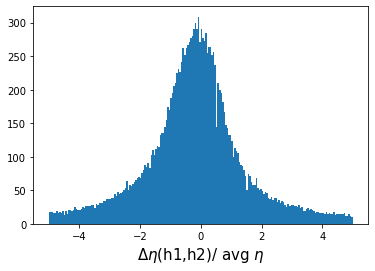

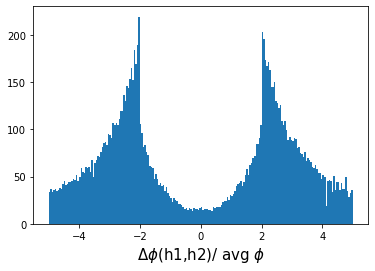

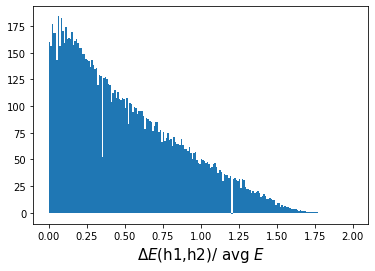

In [26]:
for v, xrange, xlabel in zip([h_pt,h_eta,h_phi,h_E],
                             [(0,1.5),(-5,5),(-5,5),(0,2)],
                             ['$p_T$','$\eta$','$\phi$','$E$']):
    plt.figure()
    dv = v[:,0]-v[:,1]
    vavg = 0.5*(v[:,0]+v[:,1])
    if xlabel == '$\phi$':
        dv = np.arccos(np.cos(dv))
    plt.hist(dv/vavg,200,xrange,weights=w)
    plt.xlabel('$\Delta$'+xlabel+'(h1,h2)'+'/ avg '+xlabel,fontsize=15)
plt.show()

Ok, maybe I fucked something up - but these don't look as intuitive to me.

**Next:** Look at the Euclidean distances for the truth $b$-quark pairs.

In [27]:
b_pt =  pt[np.abs(pdg) == 5].reshape(-1,4)
b_eta = eta[np.abs(pdg) == 5].reshape(-1,4)
b_phi = phi[np.abs(pdg) == 5].reshape(-1,4)
b_E   = E[np.abs(pdg) == 5].reshape(-1,4)

In [28]:
b_pt[0]

array([105.07148 ,  83.69894 ,  68.90721 ,  57.985214], dtype=float32)

In [29]:
b_eta[0]

array([0.2509805 , 1.7127913 , 0.72105324, 2.2229528 ], dtype=float32)

In [30]:
b_E[0]

array([108.47951, 239.61572,  87.71055, 270.9061 ], dtype=float32)

In [31]:
b_parent_barcodes

array([[10090, 10089, 10090, 10089],
       [10112, 10111, 10111, 10112],
       [10084, 10083, 10083, 10084],
       ...,
       [10095, 10096, 10095, 10096],
       [10072, 10071, 10071, 10072],
       [10109, 10110, 10109, 10110]], dtype=int32)

In [32]:
higgs_barcodes[:,0].reshape(-1,1)

array([[10090],
       [10112],
       [10083],
       ...,
       [10095],
       [10071],
       [10109]], dtype=int32)

In [33]:
b_parent_barcodes == higgs_barcodes[:,0].reshape(-1,1)

array([[ True, False,  True, False],
       [ True, False, False,  True],
       [False,  True,  True, False],
       ...,
       [ True, False,  True, False],
       [False,  True,  True, False],
       [ True, False,  True, False]])

In [34]:
np.sum(b_parent_barcodes == higgs_barcodes[:,0].reshape(-1,1),axis=0)

array([563414, 268278, 402426, 320182])

Let's try to retrieve indices for the bs

In [35]:
cols = [f'pair{pi}_b{i}{j}' for pi in range(3) for i in [1,2] for j in [1,2] ]
cols += ['correctPair']

In [36]:
df = pd.DataFrame(0, range(pt.shape[0]),cols)

In [37]:
b_pt.shape

(777150, 4)

In [38]:
for pi, (i11, i12, i21, i22) in enumerate([(0,1,2,3), (0,2,1,3), (0,3,1,2)]):
    
    print(f'HC1 : {i11} {i12}, HC2: {i21} {i22}')
    
    j11 = TLorentzVectorArray.from_ptetaphi(b_pt[:,i11], b_eta[:,i11], b_phi[:,i11], b_E[:,i11])
    j12 = TLorentzVectorArray.from_ptetaphi(b_pt[:,i12], b_eta[:,i12], b_phi[:,i12], b_E[:,i12])
    j21 = TLorentzVectorArray.from_ptetaphi(b_pt[:,i21], b_eta[:,i21], b_phi[:,i21], b_E[:,i21])
    j22 = TLorentzVectorArray.from_ptetaphi(b_pt[:,i22], b_eta[:,i22], b_phi[:,i22], b_E[:,i22])

    mask = (j11+j12).pt > (j21+j22).pt
    
    # Fill the leading HC entries
    df[f'pair{pi}_b11_pt']  = np.where(mask, j11.pt,  j21.pt)
    df[f'pair{pi}_b11_eta'] = np.where(mask, j11.eta, j21.eta)
    df[f'pair{pi}_b11_phi'] = np.where(mask, j11.phi, j21.phi)
    df[f'pair{pi}_b11_E']   = np.where(mask, j11.E,   j21.E)
    
    df[f'pair{pi}_b12_pt']  = np.where(mask, j12.pt,  j22.pt)
    df[f'pair{pi}_b12_eta'] = np.where(mask, j12.eta, j22.eta)
    df[f'pair{pi}_b12_phi'] = np.where(mask, j12.phi, j22.phi)
    df[f'pair{pi}_b12_E']   = np.where(mask, j12.E,   j22.E)
    
    # Fill the subleading HC entries
    df[f'pair{pi}_b21_pt']  = np.where(~mask, j11.pt,  j21.pt)
    df[f'pair{pi}_b21_eta'] = np.where(~mask, j11.eta, j21.eta)
    df[f'pair{pi}_b21_phi'] = np.where(~mask, j11.phi, j21.phi)
    df[f'pair{pi}_b21_E']   = np.where(~mask, j11.E,   j21.E)
    
    df[f'pair{pi}_b22_pt']  = np.where(~mask, j12.pt,  j22.pt)
    df[f'pair{pi}_b22_eta'] = np.where(~mask, j12.eta, j22.eta)
    df[f'pair{pi}_b22_phi'] = np.where(~mask, j12.phi, j22.phi)
    df[f'pair{pi}_b22_E']   = np.where(~mask, j12.E,   j22.E)
    
    # Save whether this is the correct pair or not
    m2 = (b_parent_barcodes == higgs_barcodes[:,0].reshape(-1,1))
    correctPair = (m2[:,i11] & m2[:,i12]) | (m2[:,i21] & m2[:,i22])
    df.loc[correctPair,'correctPair'] = pi
    

HC1 : 0 1, HC2: 2 3
HC1 : 0 2, HC2: 1 3
HC1 : 0 3, HC2: 1 2


In [39]:
m2[:,0] & m2[:,2]

array([ True, False, False, ...,  True, False,  True])

In [40]:
np.unique(df.correctPair,return_counts=True)

(array([0, 1, 2]), array([ 57658, 210658, 508834]))

In [41]:
den = np.sum(w)
for pi in [0,1,2]:
    x = np.sum(w[df.correctPair==pi]) / den
    print(f'Pair {pi}: {100*x:.1f}')

Pair 0: 9.0
Pair 1: 29.8
Pair 2: 61.2


Ok - I need these numbers in terms of a weighted sum!!

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


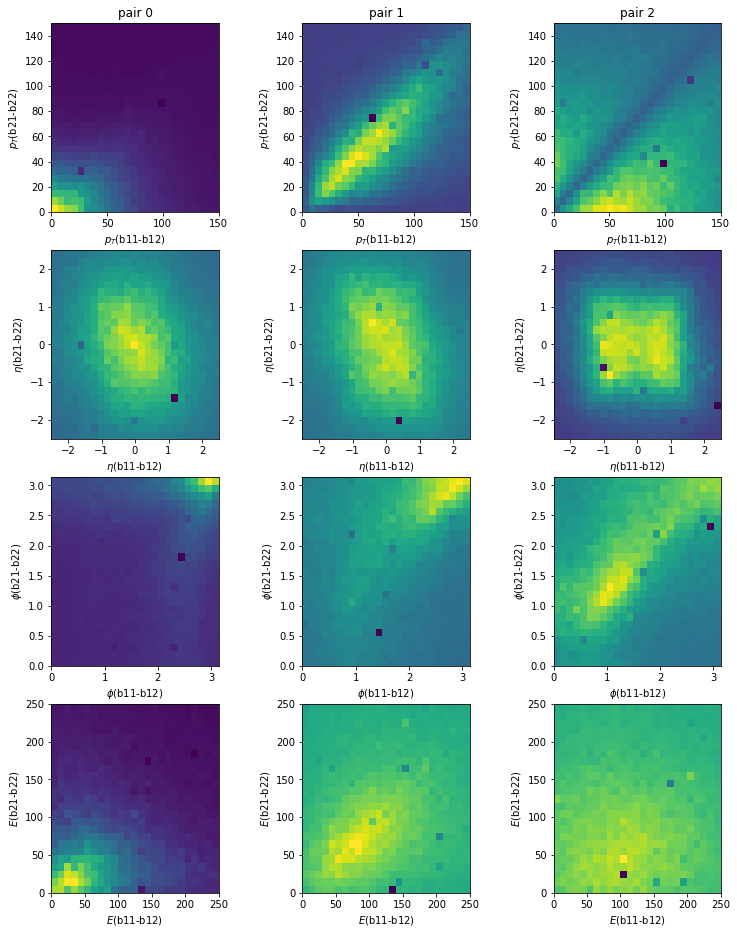

In [54]:
fig, axes = plt.subplots(4,3,figsize=(12,16))

for pi in range(3):
    
    # pt
    axes[0,pi].hist2d(df[f'pair{pi}_b11_pt'] - df[f'pair{pi}_b12_pt'],
                      df[f'pair{pi}_b21_pt'] - df[f'pair{pi}_b22_pt'],
                      25,[[0,150],[0,150]],weights=w)

    axes[0,pi].set_xlabel('$p_T$(b11-b12)')
    axes[0,pi].set_ylabel('$p_T$(b21-b22)')
    axes[0,pi].set_title(f'pair {pi}')
    axes[0,]
    
    # eta
    axes[1,pi].hist2d(df[f'pair{pi}_b11_eta'] - df[f'pair{pi}_b12_eta'],
                      df[f'pair{pi}_b21_eta'] - df[f'pair{pi}_b22_eta'],
                      25,[[-2.5,2.5],[-2.5,2.5]],weights=w)

    axes[1,pi].set_xlabel('$\eta$(b11-b12)')
    axes[1,pi].set_ylabel('$\eta$(b21-b22)')
    
    # phi
    axes[2,pi].hist2d(np.arccos(np.cos(df[f'pair{pi}_b11_phi'] - df[f'pair{pi}_b12_phi'])),
                      np.arccos(np.cos(df[f'pair{pi}_b21_phi'] - df[f'pair{pi}_b22_phi'])),
                      25,[[0,np.pi],[0,np.pi]],weights=w)

    axes[2,pi].set_xlabel('$\phi$(b11-b12)')
    axes[2,pi].set_ylabel('$\phi$(b21-b22)')
    
    # E
    axes[3,pi].hist2d(df[f'pair{pi}_b11_E'] - df[f'pair{pi}_b12_E'],
                      df[f'pair{pi}_b21_E'] - df[f'pair{pi}_b22_E'],
                      25,[[0,250],[0,250]],weights=w)

    axes[3,pi].set_xlabel('$E$(b11-b12)')
    axes[3,pi].set_ylabel('$E$(b21-b22)') 
    
fig.subplots_adjust(wspace=.5)
plt.savefig('figures/truth_b_vars_allPairs.pdf',bbox_inches='tight')
fig.show()

Ok, this looks cool already. One of the things that I like right off the bat is how we can see how the kinematics vary with these types of pairings. It seems like angular information might be the most helpful, and interestingly, it's more likely to pair the highest $p_T$ quark with the lowest $p_T$ quark.

**Next:** Maybe some scatter plots to separate out info for correct vs incorrect pairs?

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


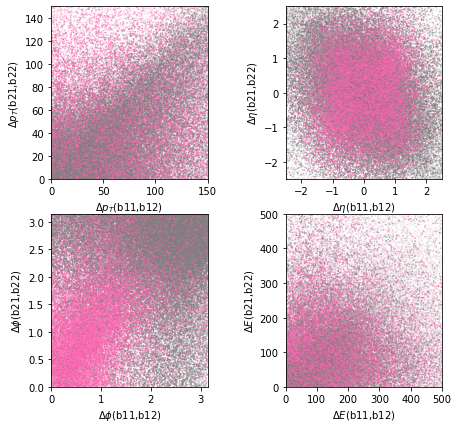

In [124]:
N=50000
s=w[:N]
alpha=1

fig, axes = plt.subplots(2,2,figsize=(7,7))

for pi in range(3):
    
    
    colors=['hotpink' if cp==pi else 'grey' for cp in df.correctPair][:N]
    
    axes[0,0].scatter((df[f'pair{pi}_b11_pt'] - df[f'pair{pi}_b12_pt'])[:N],
                      (df[f'pair{pi}_b21_pt'] - df[f'pair{pi}_b22_pt'])[:N],
                      s=s, alpha=alpha, color=colors)

    axes[0,0].set_xlabel('$\Delta p_T$(b11,b12)')
    axes[0,0].set_ylabel('$\Delta p_T$(b21,b22)')
    axes[0,0].set_xlim(0,150)
    axes[0,0].set_ylim(0,150)
    
    # eta
    axes[0,1].scatter((df[f'pair{pi}_b11_eta'] - df[f'pair{pi}_b12_eta'])[:N],
                      (df[f'pair{pi}_b21_eta'] - df[f'pair{pi}_b22_eta'])[:N],
                      s=s, alpha=alpha, color=colors)
    
    axes[0,1].set_xlabel('$\Delta\eta$(b11,b12)')
    axes[0,1].set_ylabel('$\Delta\eta$(b21,b22)')
    axes[0,1].set_xlim(-2.5,2.5)
    axes[0,1].set_ylim(-2.5,2.5)
    
    # phi
    axes[1,0].scatter(np.arccos(np.cos(df[f'pair{pi}_b11_phi'] - df[f'pair{pi}_b12_phi']))[:N],
                      np.arccos(np.cos(df[f'pair{pi}_b21_phi'] - df[f'pair{pi}_b22_phi']))[:N],
                      s=s, alpha=alpha, color=colors)

    axes[1,0].set_xlabel('$\Delta\phi$(b11,b12)')
    axes[1,0].set_ylabel('$\Delta\phi$(b21,b22)')
    axes[1,0].set_xlim(0,np.pi)
    axes[1,0].set_ylim(0,np.pi)
    
    # E
    axes[1,1].scatter((df[f'pair{pi}_b11_E'] - df[f'pair{pi}_b12_E'])[:N],
                      (df[f'pair{pi}_b21_E'] - df[f'pair{pi}_b22_E'])[:N],
                      s=s, alpha=alpha, color=colors)

    axes[1,1].set_xlabel('$\Delta E$(b11,b12)')
    axes[1,1].set_ylabel('$\Delta E$(b21,b22)') 
    axes[1,1].set_xlim(0,500)
    axes[1,1].set_ylim(0,500)
    
fig.subplots_adjust(wspace=.5)
plt.savefig('figures/truth_b_vars_correctIncorrectPairs.png',bbox_inches='tight')

fig.show()

This is just saying that $\Delta \phi$ and $\Delta \eta$ are good variables (like duh - but still nice to see lol).

Ok, cool! As expected, taking the log makes these look a lot more meaninful.

**Let's overlay histograms for correct and incorrect pairs**


In [46]:
correct = np.zeros((len(df),3)).astype(bool)

for pi in range(3):
    correct[df.correctPair==pi, pi]=True

In [47]:
dlogpt1 = np.log(df[[f'pair{pi}_b11_pt' for pi in range(3)]]).values - np.log(df[[f'pair{pi}_b12_pt' for pi in range(3)]]).values
dlogpt2 = np.log(df[[f'pair{pi}_b21_pt' for pi in range(3)]]).values - np.log(df[[f'pair{pi}_b22_pt' for pi in range(3)]]).values

deta1 = df[[f'pair{pi}_b11_eta' for pi in range(3)]].values - df[[f'pair{pi}_b12_eta' for pi in range(3)]].values
deta2 = df[[f'pair{pi}_b21_eta' for pi in range(3)]].values - df[[f'pair{pi}_b22_eta' for pi in range(3)]].values

dphi1 = np.arccos(np.cos(df[[f'pair{pi}_b11_phi' for pi in range(3)]].values - df[[f'pair{pi}_b12_phi' for pi in range(3)]])).values
dphi2 = np.arccos(np.cos(df[[f'pair{pi}_b21_phi' for pi in range(3)]].values - df[[f'pair{pi}_b22_phi' for pi in range(3)]])).values

dlogE1 = np.log(df[[f'pair{pi}_b11_E' for pi in range(3)]]).values - np.log(df[[f'pair{pi}_b12_E' for pi in range(3)]]).values
dlogE2 = np.log(df[[f'pair{pi}_b21_E' for pi in range(3)]]).values - np.log(df[[f'pair{pi}_b22_E' for pi in range(3)]]).values

In [126]:
dlogpt1.shape

(777150, 3)

In [127]:
w_3d = np.vstack([w for i in range(3)]).T
w_3d.shape

(777150, 3)

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


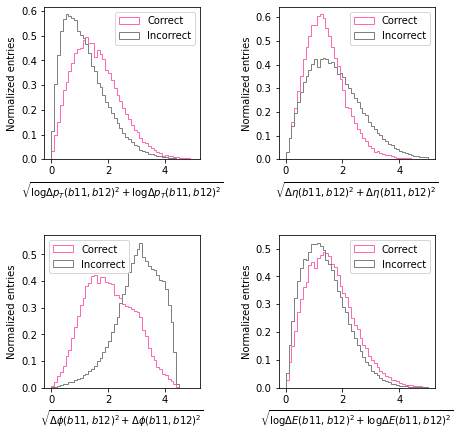

In [130]:
nBins = 50
myRange = (0,5)
fig, axes = plt.subplots(2,2,figsize=(7,7))

axes[0,0].hist(np.sqrt(dlogpt1**2+dlogpt2**2)[correct],nBins,myRange,color='hotpink',
               density=True,histtype='step',label='Correct',weights=w_3d[correct])
axes[0,0].hist(np.sqrt(dlogpt1**2+dlogpt2**2)[~correct],nBins,myRange,color='grey',
               density=True,histtype='step',label='Incorrect',weights=w_3d[~correct])

axes[0,0].set_xlabel('$\sqrt{ \log \Delta p_T(b11,b12)^2 + \log \Delta p_T(b11,b12)^2}$')
axes[0,0].set_ylabel('Normalized entries')
axes[0,0].legend()

# eta
m1,_,_ = axes[0,1].hist(np.sqrt(deta1**2+deta2**2)[correct],nBins,myRange,color='hotpink',
              density=True,histtype='step',label='Correct',weights=w_3d[correct])
m2,_,_ = axes[0,1].hist(np.sqrt(deta1**2+deta2**2)[~correct],nBins,myRange,color='grey',
              density=True,histtype='step',label='Incorrect',weights=w_3d[~correct])

axes[0,1].set_xlabel('$\sqrt{\Delta \eta (b11,b12)^2 + \Delta \eta (b11,b12)^2}$')
axes[0,1].set_ylabel('Normalized entries')
axes[0,1].legend()

# phi
axes[1,0].hist(np.sqrt(dphi1**2+dphi2**2)[correct],nBins,myRange,color='hotpink',
              density=True,histtype='step',label='Correct',weights=w_3d[correct])
axes[1,0].hist(np.sqrt(dphi1**2+dphi2**2)[~correct],nBins,myRange,color='grey',
              density=True,histtype='step',label='Incorrect',weights=w_3d[~correct])

axes[1,0].set_xlabel('$\sqrt{\Delta \phi(b11,b12)^2 + \Delta \phi (b11,b12)^2}$')
axes[1,0].set_ylabel('Normalized entries')
axes[1,0].legend(loc='upper left')


# E
axes[1,1].hist(np.sqrt(dlogE1**2+dlogE2**2)[correct],nBins,myRange,color='hotpink',
               density=True,histtype='step',label='Correct',weights=w_3d[correct])
axes[1,1].hist(np.sqrt(dlogE1**2+dlogE2**2)[~correct],nBins,myRange,color='grey',
               density=True,histtype='step',label='Incorrect',weights=w_3d[~correct])

axes[1,1].set_xlabel('$\sqrt{\log \Delta E(b11,b12)^2 + \log \Delta E(b11,b12)^2}$')
axes[1,1].set_ylabel('Normalized entries')
axes[1,1].legend()
    
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=.5)

plt.savefig('figures/truth_b_vars_correctIncorrectMarginals.png',bbox_inches='tight')
fig.show()

Ok, I think I have something fucked up rn, b/c there's a peak at around $\Delta \phi = \pi$...

Not necessarily, because this is two variables getting summed in quadrature, not one... but I'm not quite sure atm.


## Check out $\cos \theta$ instead of $\eta$

I'm not sure *why* except that Michael asked me to do this.

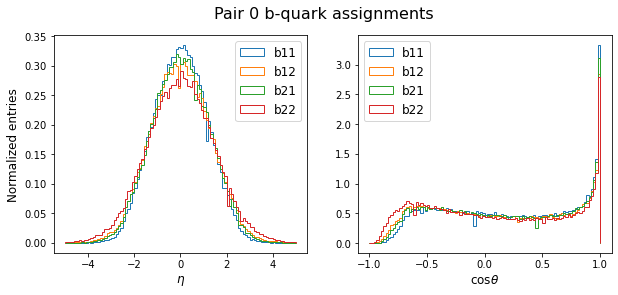

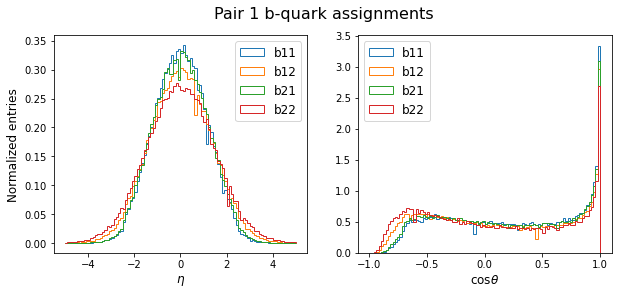

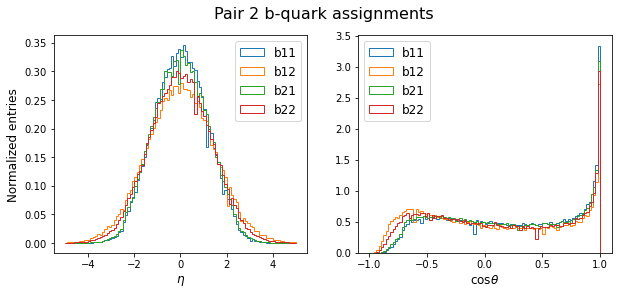

In [118]:
for pi in range(3):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))


    ax1.hist(df[f'pair{pi}_b11_eta'],nBins,(-5,5),label='b11',
             density=True,histtype='step',weights=w)
    ax1.hist(df[f'pair{pi}_b12_eta'],nBins,(-5,5),label='b12',
             density=True,histtype='step',weights=w)
    ax1.hist(df[f'pair{pi}_b21_eta'],nBins,(-5,5),label='b21',
             density=True,histtype='step',weights=w)
    ax1.hist(df[f'pair{pi}_b22_eta'],nBins,(-5,5),label='b22',
             density=True,histtype='step',weights=w)

    ax2.hist(np.cos(2*np.arctan(-df[f'pair{pi}_b11_eta'])),nBins,(-1,1),
             label='b11',density=True,histtype='step',weights=w)
    ax2.hist(np.cos(2*np.arctan(-df[f'pair{pi}_b12_eta'])),nBins,(-1,1),
             label='b12',density=True,histtype='step',weights=w)
    ax2.hist(np.cos(2*np.arctan(-df[f'pair{pi}_b21_eta'])),nBins,(-1,1),
             label='b21',density=True,histtype='step',weights=w)
    ax2.hist(np.cos(2*np.arctan(-df[f'pair{pi}_b22_eta'])),nBins,(-1,1),
             label='b22',density=True,histtype='step',weights=w)

    ax1.set_xlabel('$\eta$',fontsize=12)
    ax2.set_xlabel(r'$\cos \theta$',fontsize=12)
    ax1.set_ylabel('Normalized entries',fontsize=12)

    ax1.legend(fontsize=12)
    ax2.legend(loc='upper left',fontsize=12)

    fig.suptitle(f'Pair {pi} b-quark assignments',fontsize=16)

    plt.savefig(f'figures/eta_vs_cosTheta_pair{pi}.pdf',bbox_inches='tight')
    plt.show()

In [89]:
for pi in [0,1,2]:
    for i in [1,2]:
        for j in [1,2]:
            k = f'pair{pi}_b{i}{j}'
            df[f'{k}_cosTheta'] = np.cos(2*np.arctan(-df[f'{k}_eta']))

Hmmmm - this seems interesting that the lower $p_T$ bs are less central - is this a common trend??

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


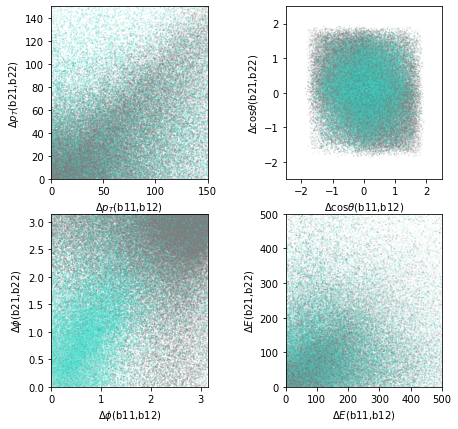

In [125]:
N=50000
s=w[:N]
alpha=.5

fig, axes = plt.subplots(2,2,figsize=(7,7))

for pi in range(3):
    
    
    colors=['turquoise' if cp==pi else 'grey' for cp in df.correctPair][:N]
    
    axes[0,0].scatter((df[f'pair{pi}_b11_pt'] - df[f'pair{pi}_b12_pt'])[:N],
                      (df[f'pair{pi}_b21_pt'] - df[f'pair{pi}_b22_pt'])[:N],
                      s=s, alpha=alpha, color=colors)

    axes[0,0].set_xlabel('$\Delta p_T$(b11,b12)')
    axes[0,0].set_ylabel('$\Delta p_T$(b21,b22)')
    axes[0,0].set_xlim(0,150)
    axes[0,0].set_ylim(0,150)
    
    # eta
    axes[0,1].scatter((df[f'pair{pi}_b11_cosTheta'] - df[f'pair{pi}_b12_cosTheta'])[:N],
                      (df[f'pair{pi}_b21_cosTheta'] - df[f'pair{pi}_b22_cosTheta'])[:N],
                      s=s, alpha=alpha, color=colors)
    
    axes[0,1].set_xlabel(r'$\Delta\cos\theta$(b11,b12)')
    axes[0,1].set_ylabel(r'$\Delta\cos\theta$(b21,b22)')
    axes[0,1].set_xlim(-2.5,2.5)
    axes[0,1].set_ylim(-2.5,2.5)
    
    # phi
    axes[1,0].scatter(np.arccos(np.cos(df[f'pair{pi}_b11_phi'] - df[f'pair{pi}_b12_phi']))[:N],
                      np.arccos(np.cos(df[f'pair{pi}_b21_phi'] - df[f'pair{pi}_b22_phi']))[:N],
                      s=s, alpha=alpha, color=colors)

    axes[1,0].set_xlabel('$\Delta\phi$(b11,b12)')
    axes[1,0].set_ylabel('$\Delta\phi$(b21,b22)')
    axes[1,0].set_xlim(0,np.pi)
    axes[1,0].set_ylim(0,np.pi)
    
    # E
    axes[1,1].scatter((df[f'pair{pi}_b11_E'] - df[f'pair{pi}_b12_E'])[:N],
                      (df[f'pair{pi}_b21_E'] - df[f'pair{pi}_b22_E'])[:N],
                      s=s, alpha=alpha, color=colors)

    axes[1,1].set_xlabel('$\Delta E$(b11,b12)')
    axes[1,1].set_ylabel('$\Delta E$(b21,b22)') 
    axes[1,1].set_xlim(0,500)
    axes[1,1].set_ylim(0,500)
    
fig.subplots_adjust(wspace=.5)
plt.savefig('figures/truth_b_vars_cosTheta_correctIncorrectPairs.png',bbox_inches='tight')

fig.show()

In [95]:
dcosTheta1 = df[[f'pair{pi}_b11_cosTheta' for pi in range(3)]].values - df[[f'pair{pi}_b12_cosTheta' for pi in range(3)]].values
dcosTheta2 = df[[f'pair{pi}_b21_cosTheta' for pi in range(3)]].values - df[[f'pair{pi}_b22_cosTheta' for pi in range(3)]].values

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


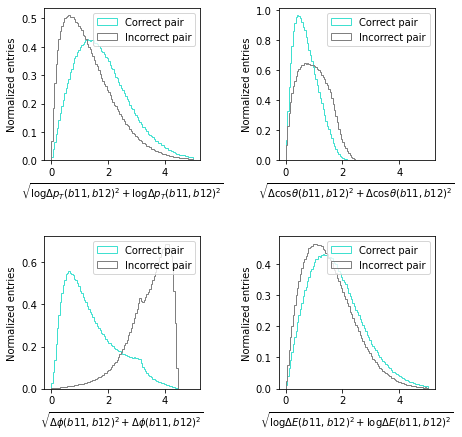

In [109]:
nBins = 100
myRange = (0,5)
fig, axes = plt.subplots(2,2,figsize=(7,7))

axes[0,0].hist(np.sqrt(dlogpt1**2+dlogpt2**2)[correct],nBins,myRange,color='turquoise',
               density=True,histtype='step',label='Correct',weights=w_3d[correct])
axes[0,0].hist(np.sqrt(dlogpt1**2+dlogpt2**2)[~correct],nBins,myRange,color='grey',
               density=True,histtype='step',label='Incorrect',weights=w_3d[correct])

axes[0,0].set_xlabel('$\sqrt{ \log \Delta p_T(b11,b12)^2 + \log \Delta p_T(b11,b12)^2}$')
axes[0,0].set_ylabel('Normalized entries')
axes[0,0].legend()

# cosTheta
n1,_,_ = axes[0,1].hist(np.sqrt(dcosTheta1**2+dcosTheta2**2)[correct],nBins,myRange,color='turquoise',
              density=True,histtype='step',label='Correct',weights=w_3d[correct])
n2,_,_ = axes[0,1].hist(np.sqrt(dcosTheta1**2+dcosTheta2**2)[~correct],nBins,myRange,color='grey',
              density=True,histtype='step',label='Incorrect',weights=w_3d[correct])

axes[0,1].set_xlabel(r'$\sqrt{\Delta \cos \theta (b11,b12)^2 + \Delta \cos \theta (b11,b12)^2}$')
axes[0,1].set_ylabel('Normalized entries')
axes[0,1].legend()

# phi
axes[1,0].hist(np.sqrt(dphi1**2+dphi2**2)[correct],nBins,myRange,color='turquoise',
              density=True,histtype='step',label='Correct',weights=w_3d[correct])
axes[1,0].hist(np.sqrt(dphi1**2+dphi2**2)[~correct],nBins,myRange,color='grey',
              density=True,histtype='step',label='Incorrect',weights=w_3d[correct])

axes[1,0].set_xlabel('$\sqrt{\Delta \phi(b11,b12)^2 + \Delta \phi (b11,b12)^2}$')
axes[1,0].set_ylabel('Normalized entries')
axes[1,0].legend(loc='upper left')


# E
axes[1,1].hist(np.sqrt(dlogE1**2+dlogE2**2)[correct],nBins,myRange,color='turquoise',
               density=True,histtype='step',label='Correct',weights=w_3d[correct])
axes[1,1].hist(np.sqrt(dlogE1**2+dlogE2**2)[~correct],nBins,myRange,color='grey',
               density=True,histtype='step',label='Incorrect',weights=w_3d[correct])

axes[1,1].set_xlabel('$\sqrt{\log \Delta E(b11,b12)^2 + \log \Delta E(b11,b12)^2}$')
axes[1,1].set_ylabel('Normalized entries')
axes[1,1].legend()
    
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=.5)

plt.savefig('figures/truth_b_vars_cosTheta_correctIncorrectMarginals.pdf',bbox_inches='tight')
fig.show()

Visually - $\eta$ looks like a better choice than $\cos \theta$ - I *could* verify this pretty quickly by making a roc curve though!

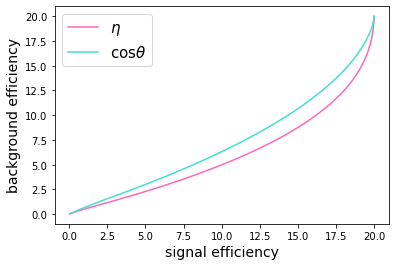

In [110]:
plt.plot(np.add.accumulate(m1), np.add.accumulate(m2),color='hotpink',label='$\eta$')
plt.plot(np.add.accumulate(n1), np.add.accumulate(n2),color='turquoise',label=r'$\cos \theta$')
plt.xlabel('signal efficiency',fontsize=14)
plt.ylabel('background efficiency',fontsize=14)

plt.legend(loc='upper left',fontsize=15)
plt.savefig('figures/roc_eta_v_cosTheta.pdf',bbox_inches='tight')
plt.show()

Ok - good motivation that we'll want to stick with $\eta$... and it's also better motivated for allowing the model to easily recover $\min \Delta R_{jj}^{HC 1}$ which I saw was pretty good for the SM point.